# Stats COurse 2023 BLAB LA

In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

### Load the dataset

In [2]:
df = pd.read_csv('data/train_test_2023.csv', encoding='ISO-8859-1')

### Preprocess the dataset

In [8]:
def preprocess_data(df):
    """
    Preprocess the dataset for XGBoost model training.
    
    This function encodes categorical variables using one-hot encoding, 
    then splits the dataset into features (X) and target (y), 
    and further into training and testing sets.

    :param df: Pandas DataFrame containing the dataset.
    :return: Tuple of (X_train, X_test, y_train, y_test)
    """
    # Renaming the target column for clarity
    df.rename(columns={'': 'target'}, inplace=True)

    # Identifying categorical and numerical columns
    categorical_cols = df.select_dtypes(include=['object']).columns
    categorical_cols = categorical_cols.drop('target')  # Exclude the target column
    numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns

    # Defining the transformer for categorical data
    transformer = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
        ],
        remainder='passthrough'
    )

    # Splitting the dataset into features and target
    X = df.drop('target', axis=1)
    y = df['target']
    
    # Binary encoding the target column
    y = np.where(y == 'yes', 1, 0)

    # Applying transformation to the features
    X_transformed = transformer.fit_transform(X)

    # Splitting the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=42)

    return X_train, X_test, y_train, y_test


In [9]:
X_train, X_test, y_train, y_test = preprocess_data(df)

### Logistic regression

In [12]:
def train_logistic_regression(X_train, y_train, X_test, y_test):
    """
    Train a logistic regression model and evaluate it on the test data.

    :param X_train: Training features.
    :param y_train: Training target.
    :param X_test: Testing features.
    :param y_test: Testing target.
    :return: A tuple containing the trained model and a dictionary of evaluation metrics.
    """
    # Initializing the logistic regression model
    model = LogisticRegression(max_iter=1000)  # Increasing max_iter for convergence

    # Training the model
    model.fit(X_train, y_train)

    # Making predictions on the test set
    y_pred = model.predict(X_test)

    # Calculating evaluation metrics
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, average='binary', pos_label=1),  # Replace 'your_positive_class'
        'recall': recall_score(y_test, y_pred, average='binary', pos_label=1),  # Replace 'your_positive_class'
        'f1_score': f1_score(y_test, y_pred, average='binary', pos_label= 1)  # Replace 'your_positive_class'
    }

    return model, metrics



In [13]:
model, metrics = train_logistic_regression(X_train, y_train, X_test, y_test)
print(metrics)

{'accuracy': 0.7895, 'precision': 0.711764705882353, 'recall': 0.24543610547667344, 'f1_score': 0.36500754147812975}


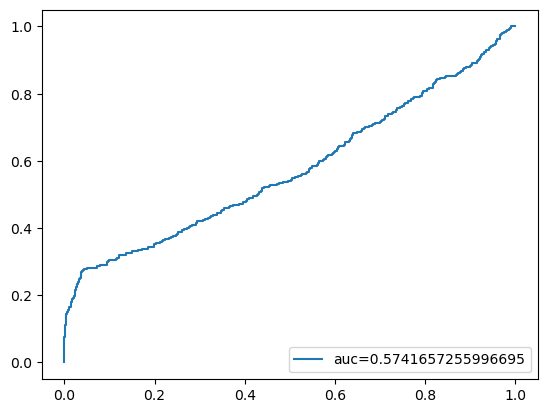

In [23]:
# Plot AUC and ROC  
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
y_pred_proba = model.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = auc(fpr,tpr)
plt.plot(fpr,tpr,label="auc="+str(auc))
plt.legend(loc=4)
plt.show()



### Classification tree

In [14]:
def train_decision_tree(X_train, y_train, X_test, y_test):
    """
    Train a decision tree classifier and evaluate it on the test data.

    :param X_train: Training features.
    :param y_train: Training target.
    :param X_test: Testing features.
    :param y_test: Testing target.
    :return: A tuple containing the trained model and a dictionary of evaluation metrics.
    """
    # Initializing the decision tree classifier
    model = DecisionTreeClassifier()

    # Training the model
    model.fit(X_train, y_train)

    # Making predictions on the test set
    y_pred = model.predict(X_test)

    # Calculating evaluation metrics
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, average='binary', pos_label=1),  # Replace 'your_positive_class'
        'recall': recall_score(y_test, y_pred, average='binary', pos_label=1),  # Replace 'your_positive_class'
        'f1_score': f1_score(y_test, y_pred, average='binary', pos_label=1)  # Replace 'your_positive_class'
    }

    return model, metrics


In [17]:
tree_model, tree_metrics = train_decision_tree(X_train, y_train, X_test, y_test)
print(tree_metrics)

{'accuracy': 0.7885, 'precision': 0.5697211155378487, 'recall': 0.5801217038539553, 'f1_score': 0.5748743718592965}


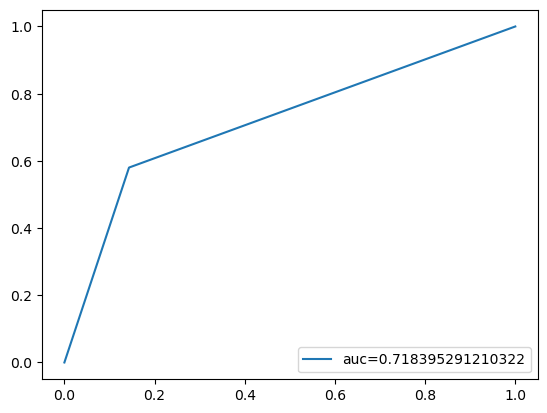

In [24]:
# Plot AUC and ROC
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
y_pred_proba = tree_model.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = auc(fpr,tpr)
plt.plot(fpr,tpr,label="auc="+str(auc))
plt.legend(loc=4)
plt.show()
    

### XGBoost

In [21]:
def train_xgboost_with_gridsearch(X_train, y_train, X_test, y_test):
    """
    Train an XGBoost model with hyperparameter tuning using grid search and evaluate it on the test data.

    :param X_train: Training features.
    :param y_train: Training target.
    :param X_test: Testing features.
    :param y_test: Testing target.
    :return: A tuple containing the best model from grid search and a dictionary of evaluation metrics.
    """
    # Define the parameter grid
    param_grid = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 4, 5]
    }

    # Initializing the XGBoost classifier
    xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

    # Setting up GridSearchCV
    grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

    # Performing grid search
    grid_search.fit(X_train, y_train)

    # Best model
    best_model = grid_search.best_estimator_

    # Making predictions on the test set with the best model
    y_pred = best_model.predict(X_test)

    # Calculating evaluation metrics
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, average='binary', pos_label=1),  # Replace 'your_positive_class'
        'recall': recall_score(y_test, y_pred, average='binary', pos_label=1),  # Replace 'your_positive_class'
        'f1_score': f1_score(y_test, y_pred, average='binary', pos_label=1)  # Replace 'your_positive_class'
    }

    return best_model, metrics


In [22]:
# Example usage (replace with your actual data):
best_xgb_model, xgb_metrics = train_xgboost_with_gridsearch(X_train, y_train, X_test, y_test)
print("Best Model Parameters:", best_xgb_model.get_params())
print("Evaluation Metrics:", xgb_metrics)


/opt/anaconda3/envs/TP1/lib/python3.10/site-packages/xgboost/sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/opt/anaconda3/envs/TP1/lib/python3.10/site-packages/xgboost/sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/opt/anaconda3/envs/TP1/lib/python3.10/site-packages/xgboost/sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Fitting 3 folds for each of 27 candidates, totalling 81 fits


[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   2.2s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   2.2s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   2.3s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time=   3.7s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time=   6.2s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time=   6.2s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=300; total time=   8.1s
[CV] END ..learning_rate=0.01, max_depth=4, n_estimators=100; total time=   2.1s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=300; total time=   8.3s
[CV] END ..learning_rate=0.01, max_depth=4, n_estimators=100; total time=   2.0s
[CV] END ..learning_rate=0.01, max_depth=4, n_estimators=100; total time=   2.0s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=300; total time=   4.6s
[CV] END ..learning_rate=0.0

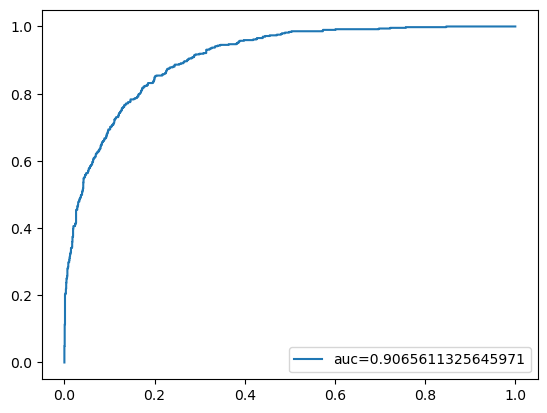

In [25]:
# Plot AUC and ROC
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
y_pred_proba = best_xgb_model.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = auc(fpr,tpr)
plt.plot(fpr,tpr,label="auc="+str(auc))
plt.legend(loc=4)
plt.show()
